# Iris Tutorial

In [1]:
library(dbscan)
library(ggplot2)
library(MASS)
library(FactoMineR)
library(repr)
library(scatterplot3d)
library(uwot)
library(kernlab)
library(microbenchmark)


Caricamento pacchetto: ‘dbscan’


Il seguente oggetto è mascherato da ‘package:stats’:

    as.dendrogram


Caricamento del pacchetto richiesto: Matrix


Caricamento pacchetto: ‘kernlab’


Il seguente oggetto è mascherato da ‘package:ggplot2’:

    alpha




In [2]:
options(repr.plot.width=6, repr.plot.height=6)

Functions for tSNE.

In [3]:
source("./functions.R")

Opening the data

In [4]:
data(iris)

separate labels and features

In [5]:
X <- iris[c("Sepal.Width","Sepal.Length",
            "Petal.Width","Petal.Length")]

In [6]:
labels <- iris[['Species']]

Species colors

In [7]:
colors <- c("#999999", "#E69F00", "#56B4E9")
colors <- colors[as.numeric(labels)]

## Plot two dimensions

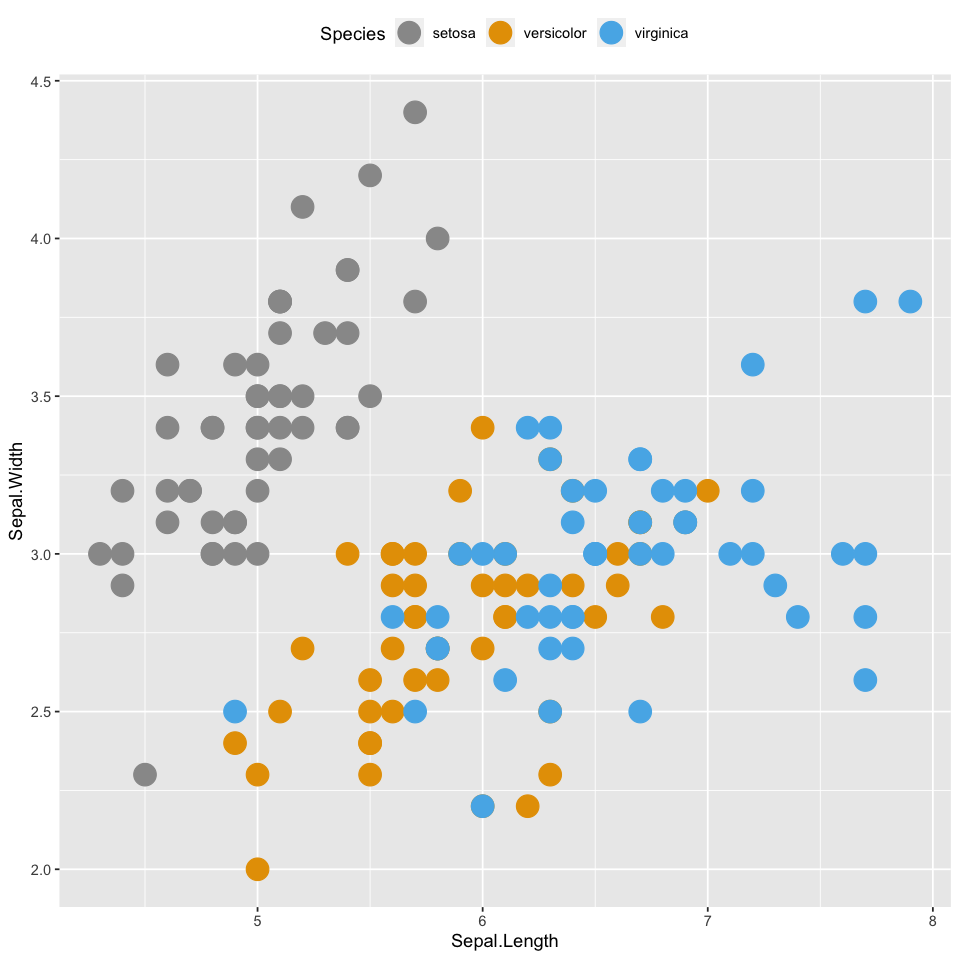

In [762]:
options(repr.plot.width=8, repr.plot.height=8)
ggplot(iris, aes(x=Sepal.Length, y=Sepal.Width, color=Species)) +
  geom_point(size=6) + 
  scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
  theme(legend.position="top")

## Plot three dimensions

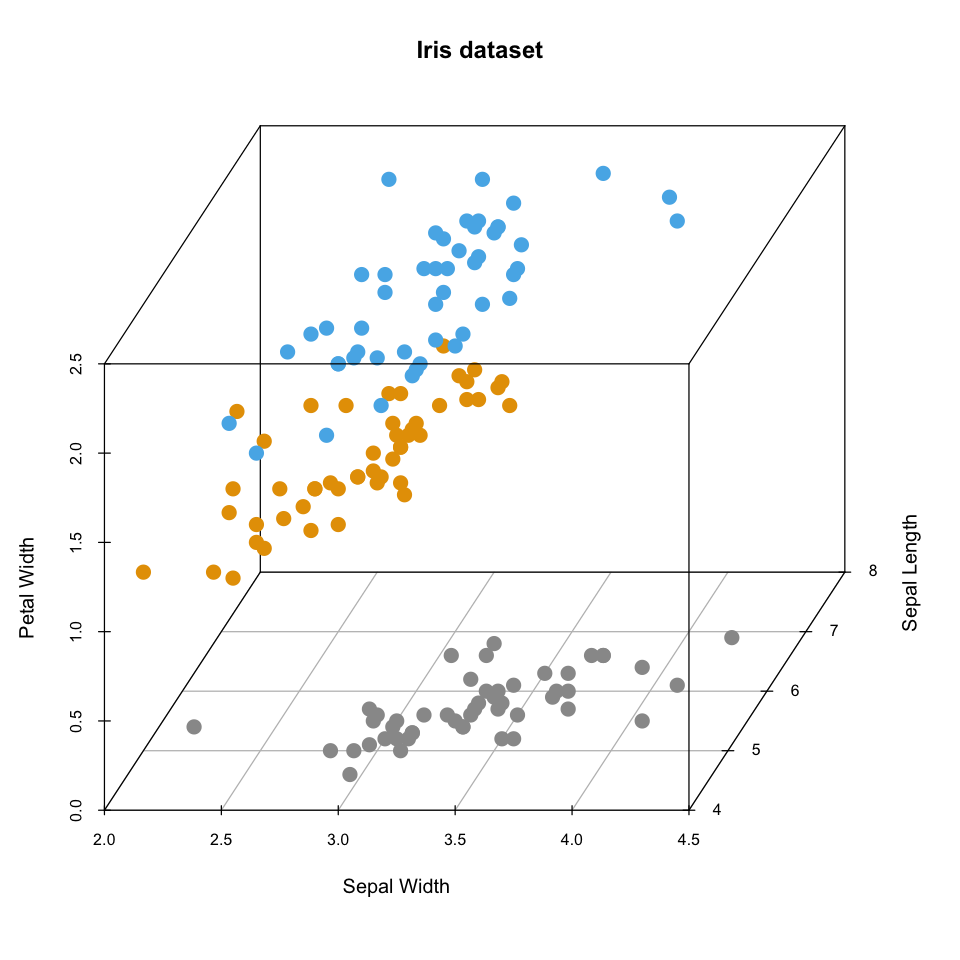

In [763]:
scatterplot3d(iris[["Sepal.Width"]],  
              iris[["Sepal.Length"]],
              iris[["Petal.Width"]],
              color=colors,
              xlab="Sepal Width",
              ylab="Sepal Length",
              zlab="Petal Width",
              main = "Iris dataset",
              lwd=5, pch=19, angle=60)

## Curse of dimensionality

Calculate distances in all dimensions for Iris data and plot the histogram

In [8]:
Distance <-  as.vector(as.matrix( dist(X[,1]) ))
L <- length(Distance)
Dimension <- rep(1, L)
Ndim <- dim(X)[2]
for(n in 2:Ndim){
    Distance <- c(Distance, as.vector(as.matrix( dist(X[,1:n]) )))
    Dimension <- c(Dimension, rep(n, L))
    }

In [12]:
D <- as.data.frame(log(Distance))
colnames(D) <- c("log_distance")
D["dimension"] <- factor(Dimension)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 2294 rows containing non-finite values (`stat_bin()`).”


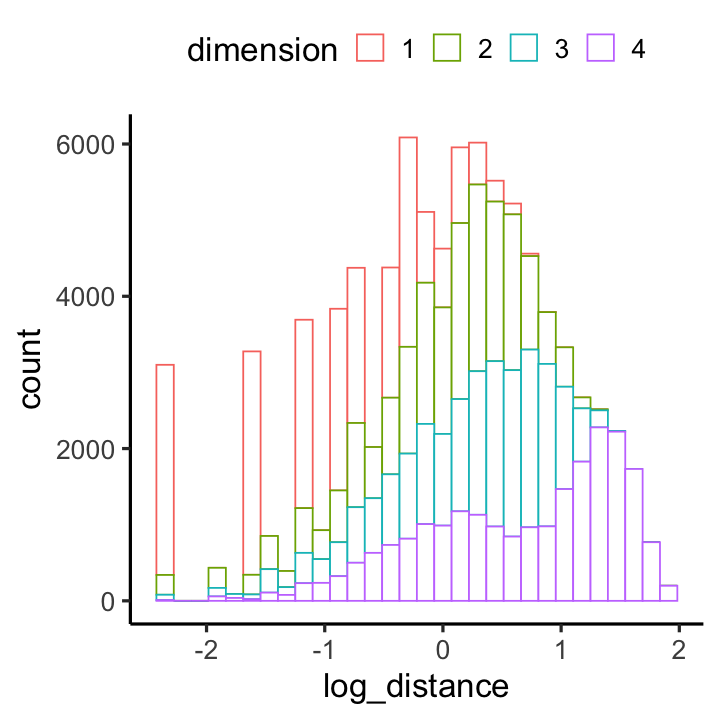

In [13]:
ggplot(D, aes(x=log_distance, color=dimension)) +
  geom_histogram(fill="white") + theme_classic(base_size = 20) +
  theme(legend.position="top")

## Parametric projections

### PCA

The function PCA is part of the package `FactomineR`

In [14]:
PCA = FactoMineR::PCA(X, ncp = 2)

In [15]:
Y_PCA = as.data.frame(PCA$ind$coord)

In [16]:
Y_PCA["labels"] <- labels

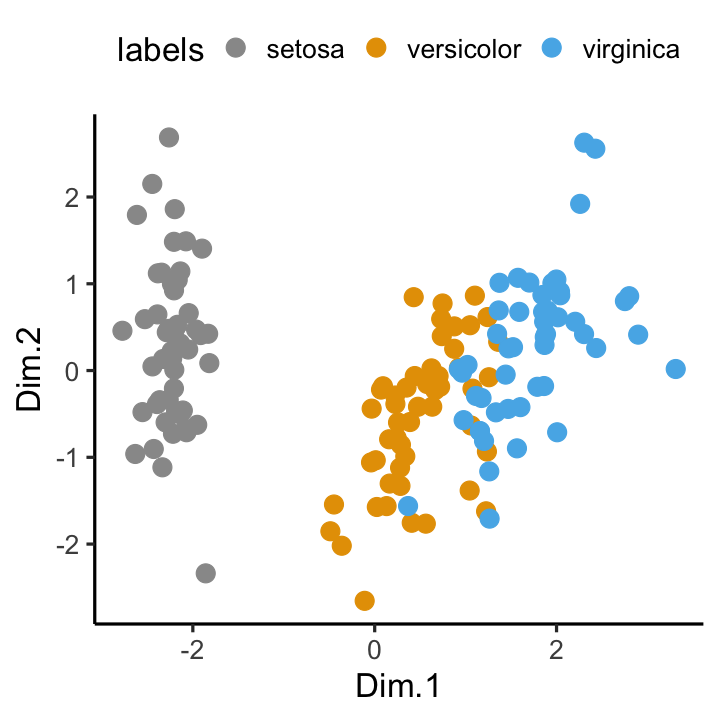

In [17]:
ggplot(Y_PCA, aes(x=Dim.1, y=Dim.2, color=labels)) +
  geom_point(size=5) + theme_classic(base_size = 20) +
  scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
  theme(legend.position="top")

### Kernel PCA 

is contained in the package `kernlab`. Try out other kernel types beyond the gaussian one. Type `help(kpca)` to see how to use the options.

Remember to standardize your data, kpca does not do that internally.

In [18]:
X_std = apply(X, 2, function(x){(x-mean(x))/sd(x)})

In [34]:
Y_kpca = kernlab::kpca(as.matrix(X_std), 
     features = 2,
     kernel = "rbfdot", 
     kpar = list(sigma = 0.1),
     th = 1e-4, 
     na.action = na.omit)

In [35]:
Y_kpca = as.data.frame(Y_kpca@pcv)

In [36]:
Y_kpca["labels"] <- labels

In [37]:
colnames(Y_kpca) <- c("Dim.1","Dim.2","labels")

Somewhat different pattern, but the same overlapping as in PCA

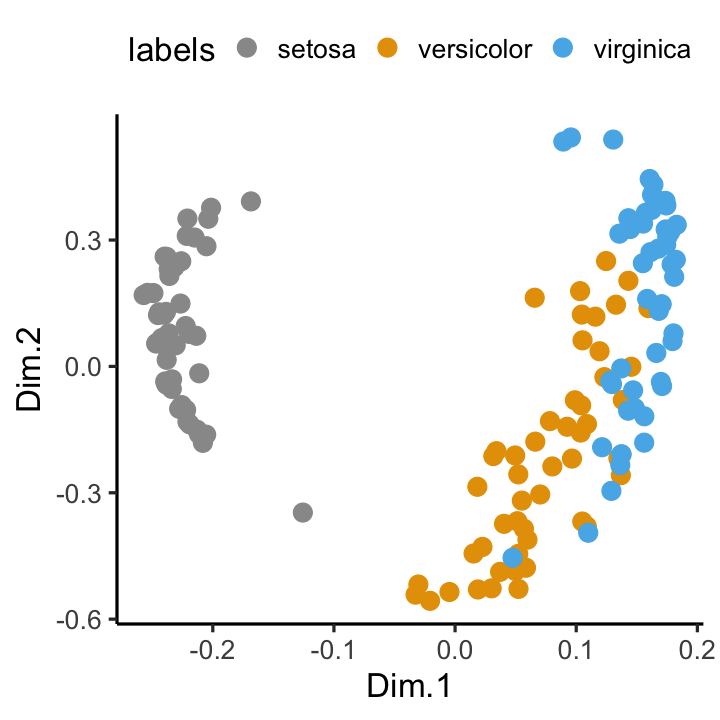

In [39]:
ggplot(Y_kpca, aes(x=Dim.1, y=Dim.2, color=labels)) +
  geom_point(size=5) + theme_classic(base_size = 20) +
  scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
  theme(legend.position="top")

### Linear Discriminant Analysis

contained in the `MASS` package. The functions run a regression based on the projection,so we provide prior probabilities for each class (they give weight to each class). `formula = Species ~ .` means that all the variables apart from thhe species labels are part of the regression (projection)

In [40]:
Y_lda <- lda(formula = Species ~ ., 
          data = iris, 
          prior = c(1,1,1)/3)

In [41]:
Y_lda$scaling

,LD1,LD2
Sepal.Length,0.8293776,-0.02410215
Sepal.Width,1.5344731,-2.16452123
Petal.Length,-2.2012117,0.93192121
Petal.Width,-2.8104603,-2.83918785


The scaling factors tell you that on the first component of the projection you have the two regression printed with the code below and so on for the other LD components


In [59]:
Ndim <- dim(X)[2]
LD <- as.character(Y_lda$scaling[,"LD1"])
FEATURE <- rownames(Y_lda$scaling)
cat("Regression for LD1 = ")
for(i in 1:Ndim-1) cat(LD[i],"*",FEATURE[i], "+", sep="") 
cat(LD[Ndim],"*",FEATURE[Ndim], "\n\n", sep="")
LD <- as.character(Y_lda$scaling[,"LD2"])
FEATURE <- rownames(Y_lda$scaling)
cat("Regression for LD2 = ")
for(i in 1:Ndim-1) cat(LD[i],"*",FEATURE[i], "+", sep="") 
cat(LD[Ndim],"*",FEATURE[Ndim], sep="")

Regression for LD1 = *+0.829377642266006*Sepal.Length+1.53447306770001*Sepal.Width+-2.20121165556177*Petal.Length+-2.8104603088431*Petal.Width

Regression for LD2 = *+-0.0241021488769744*Sepal.Length+-2.16452123465843*Sepal.Width+0.931921210029385*Petal.Length+-2.83918785298274*Petal.Width

We calculate those features using some good old vectorization in R. First take the coefficients

In [60]:
coeff_LD1 <- matrix(rep(Y_lda$scaling[,"LD1"],dim(X)[1]),
       nrow=dim(X)[1], byrow=T)

In [61]:
coeff_LD2 <- matrix(rep(Y_lda$scaling[,"LD2"],dim(X)[1]),
       nrow=dim(X)[1], byrow=T)

Then multiply by the data and do the sum by rows

In [62]:
LD1 = rowSums(X * coeff_LD1)

In [63]:
LD2 = rowSums(X * coeff_LD2)

make a proper dataframe and plot

In [64]:
Y_LDAplot <- data.frame(
                 matrix(c(LD1,LD2),
                    nrow=dim(X)[1],
                    byrow=F)
                  )
colnames(Y_LDAplot) <- c("LD1","LD2")

In [65]:
Y_LDAplot[["labels"]] <- labels

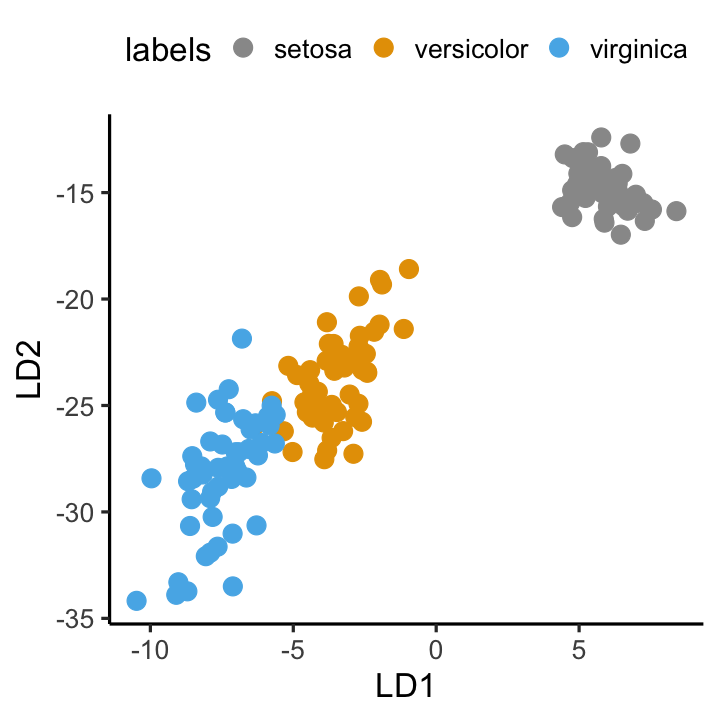

In [66]:
ggplot(Y_LDAplot, aes(x=LD1, y=LD2, color=labels)) +
  geom_point(size=5) + theme_classic(base_size = 20) +
  scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
  theme(legend.position="top")

## Non-parametric methods

### tSNE

From the code in the book or your own improved code. Remember to standardize the data first. other packages do that internally.

In [67]:
Iris_std = as.data.frame(X_std)
Iris_std["Species"] <- labels

In [68]:
head(Iris_std)

,Sepal.Width,Sepal.Length,Petal.Width,Petal.Length,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,1.01560199,-0.8976739,-1.311052,-1.335752,setosa
2,-0.13153881,-1.1392005,-1.311052,-1.335752,setosa
3,0.32731751,-1.3807271,-1.311052,-1.392399,setosa
4,0.09788935,-1.5014904,-1.311052,-1.279104,setosa
5,1.24503015,-1.0184372,-1.311052,-1.335752,setosa
6,1.93331463,-0.5353840,-1.048667,-1.165809,setosa


Run your personal tSNE function (in my case `sam_tsne`) or the one from the book (`casl_tsne`). Here `init`, `momentum` and `early_ex` are not options found in `casl_tsne`

In [69]:
Y_tsne <- sam_tsne(X_std, init = PCA$ind$coord,
                    momentum=list(init=.5, final=.9, iter=200L),
                    early_ex=list(factor=12, iter=200L), 
                    perplexity = 10, rho=100)

In [70]:
Y_tsne = as.data.frame(Y_tsne)

In [71]:
colnames(Y_tsne) <- c("tSNE1", "tSNE2")

In [72]:
Y_tsne["labels"] <- labels

In [73]:
summary(Y_tsne)

     tSNE1             tSNE2                labels  
 Min.   :-18.267   Min.   :-7.0794   setosa    :50  
 1st Qu.:-12.003   1st Qu.:-3.7153   versicolor:50  
 Median :  2.619   Median : 0.1362   virginica :50  
 Mean   :  0.000   Mean   : 0.0000                  
 3rd Qu.:  9.281   3rd Qu.: 3.2259                  
 Max.   : 17.057   Max.   : 9.0042                  

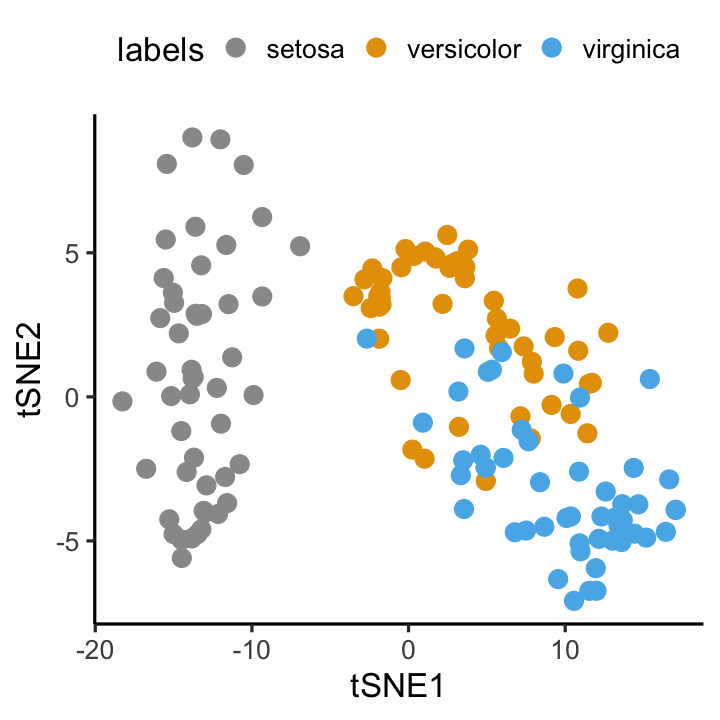

In [74]:
ggplot(Y_tsne, aes(x=tSNE1, y=tSNE2, color=labels)) +
  geom_point(size=5) + theme_classic(base_size = 20) +
  scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
  theme(legend.position="top")

#### Benchmarking the tSNEs 

Benchmarking improved tSNE VS tSNE from the book CASL and showing execution time (in seconds)

In [951]:
MB <- microbenchmark("Improved" = { sam_tsne(X_std, init = PCA$ind$coord,
                                    momentum=list(init=.5, final=.9, iter=200L),
                                    early_ex=list(factor=12, iter=200L), 
                                    perplexity = 10, rho=100) },
                     "CASL" =  { casl_tsne(X_std, init = PCA$ind$coord,
                                    perplexity = 20, rho=100) },
                      times=1 )

In [954]:
MB['time (s)'] = MB['time']/1e9

In [955]:
MB

expr,time,time (s)
<fct>,<dbl>,<dbl>
Improved,5214781303,5.214781
CASL,63844027879,63.844028


### UMAP

part of the package `uwot`

In [75]:
Y_umap <- uwot::umap(X_std, n_neighbors = 10, learning_rate = 0.5, init = "random")

In [76]:
Y_umap = as.data.frame(Y_umap)

In [77]:
colnames(Y_umap) <- c("UMAP1", "UMAP2")

In [78]:
Y_umap["labels"] <- labels

In [79]:
summary(Y_umap)

     UMAP1             UMAP2                labels  
 Min.   :-6.7011   Min.   :-4.3207   setosa    :50  
 1st Qu.:-1.1350   1st Qu.:-2.6219   versicolor:50  
 Median : 0.4624   Median :-1.0757   virginica :50  
 Mean   : 0.0000   Mean   : 0.0000                  
 3rd Qu.: 1.5604   3rd Qu.:-0.1179                  
 Max.   : 4.0514   Max.   : 7.9224                  

Umap seems to find subclusters of Iris Setosa.

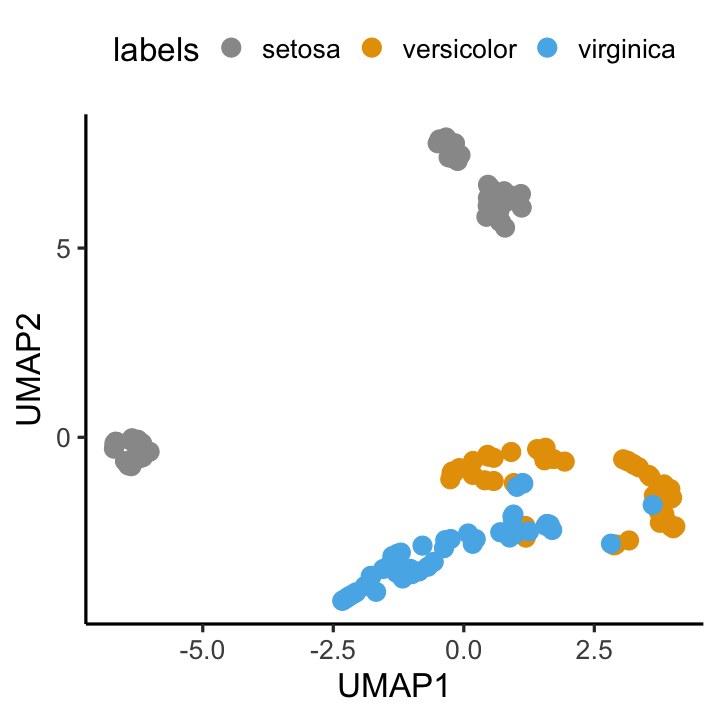

In [81]:
ggplot(Y_umap, aes(x=UMAP1, y=UMAP2, color=labels, )) +
  geom_point(size=5) + theme_classic(base_size = 20) +
  scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
  theme(legend.position="top")

## k-means clustering

k-means clustering of the umap projection to see how the clusters are different in any way.

In [82]:
res <- stats::kmeans(x=Y_umap[,c("UMAP1","UMAP2")],
              centers=6)

In [83]:
Y_kmeans <- cbind(Y_umap, factor(res$cluster), X)

In [84]:
names(Y_kmeans)[4] <- "Clusters" 

In [85]:
head(Y_kmeans)

,UMAP1,UMAP2,labels,Clusters,Sepal.Width,Sepal.Length,Petal.Width,Petal.Length
,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.8778183,6.39349442,setosa,5,3.5,5.1,0.2,1.4
2,-6.4258101,-0.74343283,setosa,3,3.0,4.9,0.2,1.4
3,-6.2399642,-0.08161170,setosa,3,3.2,4.7,0.2,1.3
4,-6.3657372,-0.09695465,setosa,3,3.1,4.6,0.2,1.5
5,1.0937697,6.42792683,setosa,5,3.6,5.0,0.2,1.4
6,-0.2533782,7.68562822,setosa,5,3.9,5.4,0.4,1.7


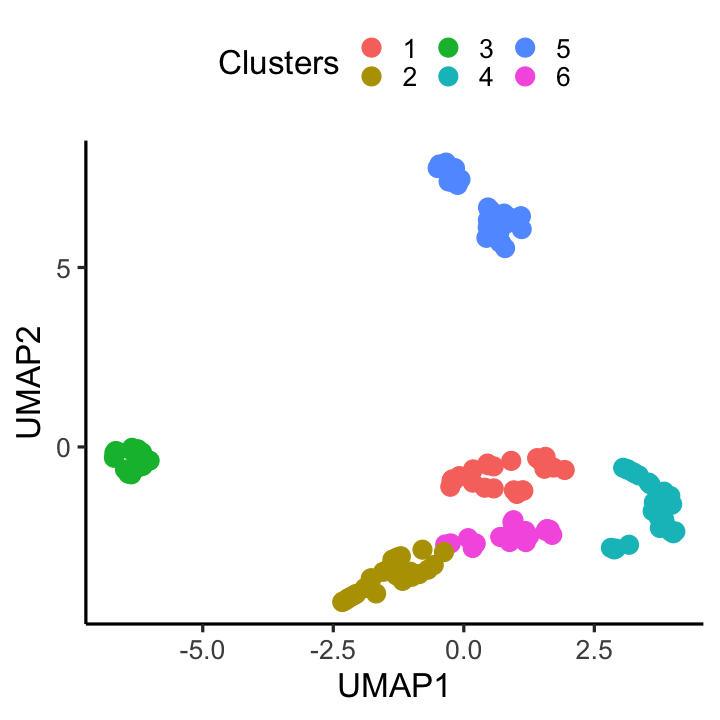

In [86]:
ggplot(Y_kmeans, aes(x=UMAP1, y=UMAP2, color=Clusters, )) +
  geom_point(size=5) + theme_classic(base_size = 20) +
  theme(legend.position="top")

Averaging by cluster

In [90]:
A <- aggregate(. ~ Clusters, Y_kmeans[c("Petal.Width","Petal.Length","Sepal.Width","Sepal.Length","Clusters")], mean)
A

Clusters,Petal.Width,Petal.Length,Sepal.Width,Sepal.Length
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.4958333,4.612500,3.012500,6.333333
2,2.1678571,5.850000,3.153571,6.982143
3,0.1941176,1.400000,3.035294,4.688235
4,1.2379310,4.020690,2.575862,5.565517
5,0.2727273,1.493939,3.630303,5.169697
6,1.8473684,5.236842,2.731579,6.173684


In [91]:
B <- aggregate(. ~ Clusters, Y_kmeans[c("Petal.Width","Petal.Length","Sepal.Width","Sepal.Length","Clusters")], sd)
B

Clusters,Petal.Width,Petal.Length,Sepal.Width,Sepal.Length
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.17810394,0.2609556,0.1623536,0.3459915
2,0.22616541,0.5036901,0.2755226,0.4981845
3,0.05557189,0.1414214,0.2119587,0.2260596
4,0.18976262,0.4435082,0.2798663,0.3538319
5,0.11530592,0.1818987,0.2709761,0.2888391
6,0.24351231,0.3094987,0.1668420,0.3052178


There is quite some difference between the two subclusters of Iris Setosa

In [99]:
print("Average and standard deviation of the difference between the two subclusters of Iris Setosa")
print(abs(A[3,2:5]-A[5,2:5]))
print(abs(B[3,2:5]+B[5,2:5]))

[1] "Average and standard deviation of the difference between the two subclusters of Iris Setosa"
  Petal.Width Petal.Length Sepal.Width Sepal.Length
3  0.07860963   0.09393939   0.5950089    0.4814617
  Petal.Width Petal.Length Sepal.Width Sepal.Length
3   0.1708778      0.32332   0.4829347    0.5148987
